**CRIME IN VANCOUVER ANALYSIS

**IMPORT LIBRARIES

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # graphing purpose
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import math

**LOAD DATA

In [2]:
crime_records = pd.read_json("data/crime/crime-vancouver.json")
#print(crime_records['YEAR'].unique())
#x = 49.23 
#y = -123.06
x = float(input("Enter x coordinate: "))
y = float(input("Enter y coordinate: "))

Enter x coordinate:  49.23
Enter y coordinate:  -123.06


**DETECT MISSING DATA

In [3]:
# reusable function for detecting missing data
def missing_value_describe(data):
    # check missing values in training data
    missing_value_stats = (data.isnull().sum() / len(data)*100)
    missing_value_col_count = sum(missing_value_stats > 0)
    missing_value_stats = missing_value_stats.sort_values(ascending=False)[:missing_value_col_count]
    print("Number of columns with missing values:", missing_value_col_count)
    if missing_value_col_count != 0:
        # print out column names with missing value percentage
        print("\nMissing percentage (desceding):")
        print(missing_value_stats)
    else:
        print("No misisng data!!!")
missing_value_describe(crime_records)

Number of columns with missing values: 4

Missing percentage (desceding):
NEIGHBOURHOOD    0.016752
X                0.009195
Y                0.009195
HUNDRED_BLOCK    0.001511
dtype: float64


**CLEANING THE DATA

In [4]:
# drop all null
crime_records = crime_records.dropna()

In [5]:
#crime_records['TYPE'].value_counts()

In [6]:
# we are concerned with crimes which can affect a restuarant
# so we remove theft of bicycle and vehicle collision
crime_records = crime_records[crime_records['TYPE'] != 'Theft of Bicycle']
crime_records = crime_records[crime_records['TYPE'] != 'Vehicle Collision or Pedestrian Struck (with Injury)']
crime_records = crime_records[crime_records['TYPE'] != 'Vehicle Collision or Pedestrian Struck (with Fatality)']
#crime_records['TYPE'].value_counts()

In [7]:
len(crime_records["HUNDRED_BLOCK"].unique())

17522

In [8]:
# remove offset to protect privacy
crime_records_without_offset = crime_records[crime_records["HUNDRED_BLOCK"] != "OFFSET TO PROTECT PRIVACY"]
#crime_records_without_offset.shape

In [9]:
#crime_records_without_offset.head()

In [10]:
# drop missing row in crime record where only 0.002% of HUNDRED_BLOCK row are missing
crime_records_without_offset = crime_records_without_offset[pd.notnull(crime_records_without_offset["HUNDRED_BLOCK"])]

In [11]:
# make sure we don't have missing row for HUNDRED_BLOCK now
block_names = crime_records_without_offset["HUNDRED_BLOCK"]
block_names.isnull().sum() 

0

In [12]:
def remove_street_number(street_name):
    # if the beginning is a digit and the street name contains more than 2 words
    if street_name[0].isdigit() and len(street_name.split(" ")) > 2:
        _, _, tail = street_name.partition(" ")
        return tail
    return street_name

# apply the above function to remove the street number in each row
crime_records_without_offset["HUNDRED_BLOCK"] = block_names.apply(remove_street_number)

In [13]:
#crime_records_without_offset["HUNDRED_BLOCK"].head()

In [14]:
# remove X NK_LOC ST
crime_records_without_offset = crime_records_without_offset[crime_records_without_offset["HUNDRED_BLOCK"]!="X NK_LOC ST"]
crime_records_without_offset = crime_records_without_offset[crime_records_without_offset["HUNDRED_BLOCK"]!='X NK_LOC ST "SQUAMISH"']
crime_records_without_offset = crime_records_without_offset[crime_records_without_offset["HUNDRED_BLOCK"]!='X NK_LOC ST "UBC"']

In [15]:
# reusable function to check the missing neighbourhood value
def missing_neighbourhood_val_count():
    return crime_records_without_offset[crime_records_without_offset["NEIGHBOURHOOD"].isnull()]["HUNDRED_BLOCK"].value_counts()
#missing_neighbourhood_val_count()

In [16]:
crime_records_without_offset.loc[crime_records_without_offset["HUNDRED_BLOCK"]=="SW MARINE DR / TAMATH CRES","NEIGHBOURHOOD"] = "Dunbar-Southlands"
#missing_neighbourhood_val_count()

In [17]:
# Victoria Avenue is actually belong to a city called White Rock. So we drop it
crime_records_without_offset = crime_records_without_offset[crime_records_without_offset["HUNDRED_BLOCK"]!="BLOCK VICTORIA AVE"]
#missing_neighbourhood_val_count()

In [18]:
# Granville St / 58th Avenue belongs to the Kerrisdale neighbourhood.
crime_records_without_offset.loc[crime_records_without_offset["HUNDRED_BLOCK"]=="GRANVILLE ST / 58TH AVE","NEIGHBOURHOOD"] = "Kerrisdale"
#missing_neighbourhood_val_count()

In [19]:
#crime_records_without_offset["NEIGHBOURHOOD"].unique()

**MORE CLEANING
WE HAVE X AND Y VALUE WITH GIVEN UTM
CONVERT THEM TO LATITUDE AND LONGITUDE

In [20]:
# https://github.com/KangboLu/UTM-to-Longtitude-Latitude-System

def utmToLatLong(utmEasting, utmNorthing, utmZone):
    eastingOffset = 500000.0
    northingOffset = 10000000.0
    k0 = 0.9996
    equatorialRadius = 6378137.0
    eccSquared = 0.006694380023
    eccPrimeSquared = eccSquared / (1 - eccSquared)
    e1 = (1 - math.sqrt(1 - eccSquared)) / (1 + math.sqrt(1 - eccSquared));
    rad2deg = 180.0/math.pi

    # Casts input from string to floats or ints
    # Removes 500,000 metre offset for longitude
    xUTM = float(utmEasting) - eastingOffset
    yUTM = float(utmNorthing)
    zoneNumber = int(utmZone)

    # Finds the origin longitude for the zone
    lonOrigin = (zoneNumber - 1) * 6 - 180 + 3 # +3 puts in zone centre

    M = yUTM / k0 #This finds the meridional arc
    mu = M / (equatorialRadius * (1- eccSquared / 4 - 3 * eccSquared * eccSquared / 64 -5 * eccSquared * eccSquared * eccSquared /256))

    # Calculates the footprint latitude
    phi1Rad = mu + (3 * e1 / 2 - 27 * e1 * e1 * e1 /32) * math.sin(2*mu) + ( 21 * e1 * e1 / 16 - 55 * e1 * e1 * e1 * e1 / 32) * math.sin( 4 * mu) + (151 * e1 * e1 * e1 / 96) * math.sin(6 * mu)
    phi1 = phi1Rad * rad2deg

    # Variables for conversion equations
    N1 = equatorialRadius / math.sqrt( 1 - eccSquared * math.sin(phi1Rad) *  math.sin(phi1Rad))
    T1 = math.tan(phi1Rad) * math.tan(phi1Rad)
    C1 = eccPrimeSquared * math.cos(phi1Rad) * math.cos(phi1Rad)
    R1 = equatorialRadius * (1 - eccSquared) / math.pow(1 - eccSquared * math.sin(phi1Rad) * math.sin(phi1Rad), 1.5)
    D = xUTM / (N1 * k0)

    # Calculate latitude, in decimal degrees
    lat = phi1Rad - ( N1 * math.tan(phi1Rad) / R1) * (D * D / 2 - (5 + 3 * T1 + 10 * C1 - 4 * C1 * C1 - 9 * eccPrimeSquared) * D * D * D * D / 24 + (61 + 90 * T1 + 298 * C1 + 45 * T1 * T1 - 252 * eccPrimeSquared - 3 * C1 * C1) * D * D * D * D * D * D / 720)
    lat = lat * rad2deg
    
    # Calculate longitude, in decimal degrees
    lon = (D - (1 + 2 * T1 + C1) * D * D * D / 6 + (5 - 2 * C1 + 28 * T1 - 3 * C1 * C1 + 8 * eccPrimeSquared + 24 * T1 * T1) * D * D * D * D * D / 120) / math.cos(phi1Rad)
    lon = lonOrigin + lon * rad2deg
    
    return lon, lat

In [21]:
crime_records_without_offset = crime_records_without_offset.reset_index(drop=True)

In [22]:
crimes_vancouver_X = crime_records_without_offset["X"]
crimes_vancouver_Y = crime_records_without_offset["Y"]
longtitude = []
latitude = []
for i in range(len(crimes_vancouver_X)):
    lon, lat = utmToLatLong(crimes_vancouver_X[i], crimes_vancouver_Y[i], 10)
    longtitude.append(lon)
    latitude.append(lat)

In [23]:
crime_records_without_offset["LONGTITUDE"] = longtitude
crime_records_without_offset["LATITUDE"] = latitude
# check for crime near your amenity
crime_records_without_offset['x2'] = (x - crime_records_without_offset['LATITUDE'])**2
crime_records_without_offset['y2'] = (y - crime_records_without_offset['LONGTITUDE'])**2
crime_records_without_offset['x2+y2'] = crime_records_without_offset['x2'] + crime_records_without_offset['y2']
crime_records_without_offset = crime_records_without_offset[crime_records_without_offset['x2+y2'] < 0.0001]
#crime_records_without_offset.head()

In [24]:
# not include the row in our analysis
crime_records_without_offset = crime_records_without_offset[crime_records_without_offset["HUNDRED_BLOCK"]!="S / L 300 BLK E HASTINGS ST"]
crime_records_without_offset = crime_records_without_offset.reset_index(drop=True) # reset index
missing_neighbourhood_val_count() # checking missing neighbourhood value

Series([], Name: HUNDRED_BLOCK, dtype: int64)

Text(0, 0.5, 'count')

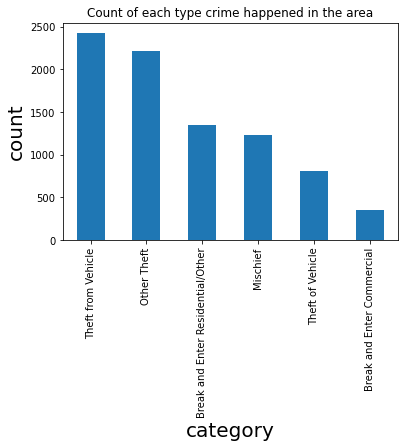

In [25]:
# crime type distribution
nameplot = crime_records_without_offset['TYPE'].value_counts().plot.bar(title='Count of each type crime happened in the area')
nameplot.set_xlabel('category',size=20)
nameplot.set_ylabel('count',size=20)

Text(0, 0.5, 'count')

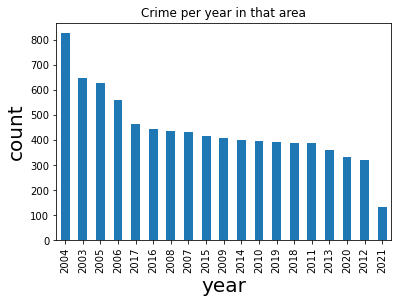

In [26]:
# check number of crimes in each year
nameplot = crime_records_without_offset['YEAR'].value_counts().plot.bar(title='Crime per year in that area')
nameplot.set_xlabel('year',size=20)
nameplot.set_ylabel('count',size=20)

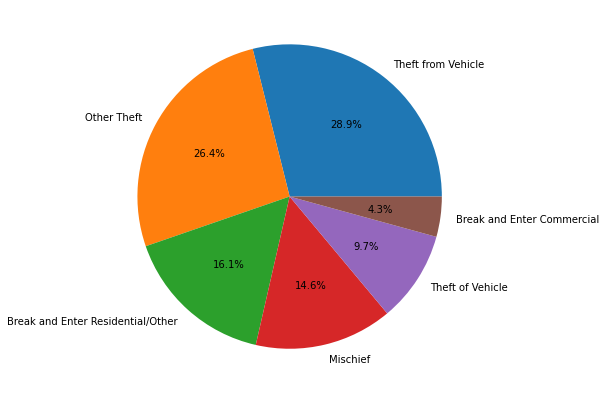

In [27]:
# pie chart to show crime distribution
df = crime_records_without_offset['TYPE'].value_counts(dropna=True)

c_df = pd.DataFrame(df)
crime_df =  c_df.reset_index()
crime_df.columns = ['type', 'counts'] 
#crime_df
fig = plt.figure(figsize =(10, 7))
plt.pie(crime_df['counts'], labels = crime_df['type'],autopct='%1.1f%%')
plt.show()

In [28]:
# return a list of latitude and longtitude data based on specified year
def get_record_locations_by_year(year):
    lat = crime_records_without_offset[crime_records_without_offset["YEAR"]==year]["LATITUDE"]
    lon = crime_records_without_offset[crime_records_without_offset["YEAR"]==year]["LONGTITUDE"]
    return list(zip(lat, lon))

In [29]:
crime_2019 = get_record_locations_by_year(2019)
crime_heatmap = folium.Map(location= [49.24, -123.11], 
                           tiles = "Stamen Toner",
                           zoom_start = 12)
HeatMap(crime_2019).add_to(crime_heatmap)
crime_heatmap

In [30]:
crime_2020 = get_record_locations_by_year(2020)
crime_heatmap = folium.Map(location= [49.24, -123.11], 
                           tiles = "Stamen Toner",
                           zoom_start = 12)
HeatMap(crime_2020).add_to(crime_heatmap)
crime_heatmap

In [31]:
crime_2021 = get_record_locations_by_year(2021)
crime_heatmap = folium.Map(location= [49.24, -123.11], 
                           tiles = "Stamen Toner",
                           zoom_start = 12)
HeatMap(crime_2021).add_to(crime_heatmap)
crime_heatmap